In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import AdamW
import torch
from torchvision import datasets, transforms
from PIL import Image
import shutil
import os
import random



Mounted at /content/drive


# **CODE FOR DATA PRE-PROCESING INCLUDING INCREASING SAMPLE SIZE THROUGH DATA AUGMENTATION**



In [ ]:
import torch
from torchvision import datasets, transforms
from PIL import Image
import shutil
import os
import random

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),                        # randomly flip images horizontally
    transforms.RandomVerticalFlip(),                          # randomly flip images vertically
    transforms.ColorJitter(brightness=0.2, contrast=0.2),     # randomly change brightness and contrast
    transforms.RandomRotation(15),                            # randomly rotate images
    transforms.RandomResizedCrop((864, 1344))                 # crop and resize

])

# directory paths
input_dir = '/content/drive/MyDrive/Charcoal Dataset'
train_dir = '/content/drive/MyDrive/Charcoal Dataset for Model/Train'
test_dir = '/content/drive/MyDrive/Charcoal Dataset for Model/Test'
val_dir = '/content/drive/MyDrive/Charcoal Dataset for Model/Validation'


# create directories for train and test sets
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# split the dataset and move test images
test_split = 0.15
val_split = 0.15
number_of_augmented_images_per_original_image = 5

for class_folder in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_folder)

    # create corresponding class folders in train and test directories
    train_class_path = os.path.join(train_dir, class_folder)
    test_class_path = os.path.join(test_dir, class_folder)
    val_class_path = os.path.join(val_dir, class_folder)
    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)
    os.makedirs(val_class_path, exist_ok=True)

    # get all images and split
    all_images = os.listdir(class_path)
    random.shuffle(all_images)
    test_index = int(len(all_images) * test_split)
    val_index = int(len(all_images) * val_split)

    test_images = all_images[:test_index]
    remaining_images = all_images[test_index:]
    val_images = remaining_images[:val_index]
    train_images = remaining_images[val_index:]

    # move test images to the test folder
    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_class_path, img))

    # move val images to val folder
    for img in val_images:
      shutil.copy(os.path.join(class_path, img), os.path.join(val_class_path, img))

    # copy train images to the train folder and apply augmentation
    for img in train_images:
        orig_img_path = os.path.join(class_path, img)
        shutil.copy(orig_img_path, os.path.join(train_class_path, img))

        img = Image.open(orig_img_path)
        for i in range(number_of_augmented_images_per_original_image):
            aug_img = transform(img)
            filename_only = os.path.basename(orig_img_path)
            filename, file_extension = os.path.splitext(filename_only)
            aug_img_path = os.path.join(train_class_path, f"aug_{i}_{filename}{file_extension}")
            aug_img.save(aug_img_path)
        img.close()

In [ ]:
dataset = datasets.ImageFolder(root=val_dir)
#data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
len(dataset)

38

# **GENERAL FUNCTION FOR TRAINING**

****OLD CODE

In [ ]:
# function to train model and returns
def train(model, num_epochs, optimizer, criterion, train_loader, val_loader, device, name):
  for epoch in range(num_epochs):

    # training
    model.train()
    total_train_loss = 0

    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

    # validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")

  # save the trained model
  path = '/content/drive/MyDrive/'+ name + '.pth'
  torch.save(model.state_dict(), path)

  return model
  # or return training and validation losses

# **EXPERIMENT #1 W/ PRETRAINED WEIGHTS**

*FINETUNING*


*   potentially add early stopping and learning rate scheduler
*   increase num epochs





In [ ]:
# load pre trained ViT and finetune on above dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTConfig, ViTForImageClassification
from transformers import AdamW

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize images to 224x224
    transforms.ToTensor(),
])

train_dir = '/content/drive/MyDrive/Charcoal Dataset for Model/Train'
val_dir = '/content/drive/MyDrive/Charcoal Dataset for Model/Validation'
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# load pre-trained ViT model configuration
config = ViTConfig.from_pretrained('google/vit-base-patch16-224')

# update the number of classes
num_classes = len(train_dataset.classes)
config.num_labels = num_classes

# initialize the model with the updated configuration
model = ViTForImageClassification(config)

# move model to GPU if available
# device = torch.device("mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5) # adam w/ weight decay
criterion = nn.CrossEntropyLoss()

# training and validation
num_epochs = 10

trained_model = train(model, num_epochs, optimizer, criterion, train_loader, val_loader, device, 'exp1_finetune')

Epoch [1/10], Training Loss: 1.5250
Epoch [1/10], Validation Loss: 1.1383
Epoch [2/10], Training Loss: 1.0442
Epoch [2/10], Validation Loss: 1.0601
Epoch [3/10], Training Loss: 0.9096
Epoch [3/10], Validation Loss: 0.9344
Epoch [4/10], Training Loss: 0.8573
Epoch [4/10], Validation Loss: 0.9316
Epoch [5/10], Training Loss: 0.8405
Epoch [5/10], Validation Loss: 0.9002
Epoch [6/10], Training Loss: 0.8001
Epoch [6/10], Validation Loss: 0.9607
Epoch [7/10], Training Loss: 0.8301
Epoch [7/10], Validation Loss: 0.9716
Epoch [8/10], Training Loss: 0.8012
Epoch [8/10], Validation Loss: 0.8842
Epoch [9/10], Training Loss: 0.7775
Epoch [9/10], Validation Loss: 0.8976
Epoch [10/10], Training Loss: 0.6927
Epoch [10/10], Validation Loss: 0.9106


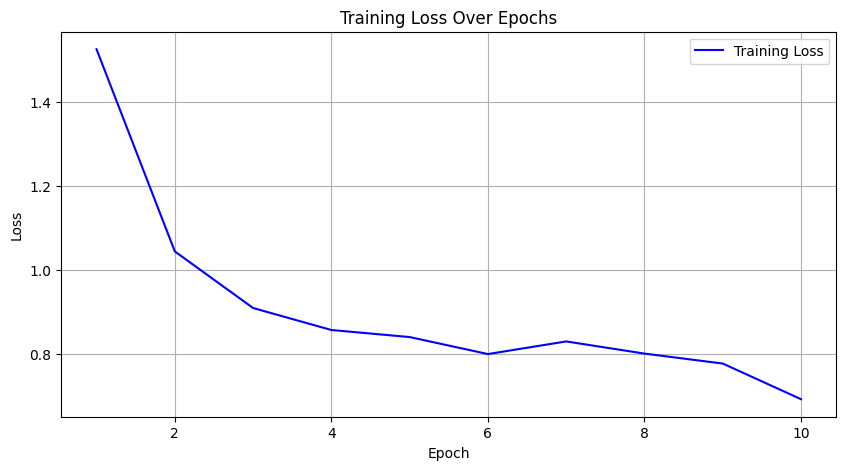

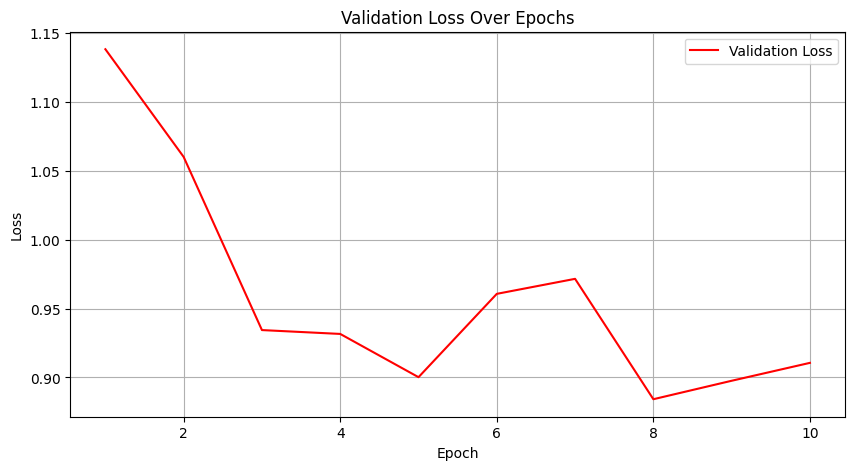

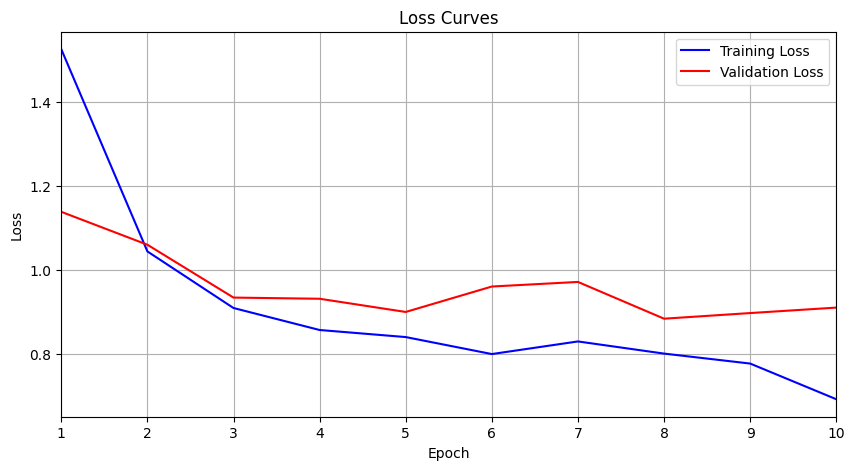

In [ ]:
import matplotlib.pyplot as plt

# Training and validation loss data
training_loss = [1.5250, 1.0442, 0.9096, 0.8573, 0.8405, 0.8001, 0.8301, 0.8012, 0.7775, 0.6927]
validation_loss = [1.1383, 1.0601, 0.9344, 0.9316, 0.9002, 0.9607, 0.9716, 0.8842, 0.8976, 0.9106]
epochs = range(1, len(training_loss) + 1)

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, color='blue', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, validation_loss, color='red', label='Validation Loss')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# train and validation curves
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, color='blue', label='Training Loss')
plt.plot(epochs, validation_loss, color='red', label='Validation Loss')
plt.xlim([1,10])
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.savefig("ViT1_loss_curves_10e.png")
plt.show()

*PERFORMANCE METRICS ON FINETUNED MODEL*

In [ ]:
# evaluation

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize images to 224x224
    transforms.ToTensor(),
])

test_dir = '/content/drive/MyDrive/Charcoal Dataset for Model/Test'
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32)

# load fine tuned model
config = ViTConfig.from_pretrained('google/vit-base-patch16-224')
num_classes = len(test_dataset.classes)
config.num_labels = num_classes
model = ViTForImageClassification(config)
model.load_state_dict(torch.load('/content/drive/MyDrive/exp1_finetune.pth', map_location=device))

# Move model to GPU if available
model.to(device)

# Evaluate the model
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs).logits

        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.view(-1).cpu().numpy())
        y_true.extend(labels.view(-1).cpu().numpy())

# Calculate metrics
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

               precision    recall  f1-score   support

  P. coronata       0.64      0.82      0.72        11
P. cynaroides       0.90      0.72      0.80        25
    P. mundii       0.47      0.64      0.54        11
    P. repens       0.43      0.33      0.38         9

     accuracy                           0.66        56
    macro avg       0.61      0.63      0.61        56
 weighted avg       0.69      0.66      0.66        56



# **EXPERIMENT 1.5: FINETUNING WITH LEARNING RATE SCHEDULER AND EARLY STOPPING**

*FINETUNING FUNCTION*

In [ ]:
import torch

def train(model, num_epochs, optimizer, criterion, train_loader, val_loader, device, name, patience=3):
    # learning rate scheduler
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8, 16, 24], gamma=0.1)

    last_val_loss = None
    epochs_no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # training
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        #print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

        # validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs).logits
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # learning rate scheduler step
        scheduler.step()

        # early stopping
        if last_val_loss is not None and avg_val_loss >= last_val_loss:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping")
                break
        else:
            epochs_no_improve = 0
            best_model_wts = model.state_dict()

        last_val_loss = avg_val_loss


    # save the best model found during training
    path = f'/content/drive/MyDrive/{name}.pth'
    torch.save(best_model_wts, path)


    return train_losses, val_losses

In [ ]:
# load pre trained ViT and finetune on above dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTConfig, ViTForImageClassification
from transformers import AdamW

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize images to 224x224
    transforms.ToTensor(),
])

train_dir = '/content/drive/MyDrive/Charcoal Dataset for Model/Train'
val_dir = '/content/drive/MyDrive/Charcoal Dataset for Model/Validation'
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

num_classes = len(train_dataset.classes)

# load pre-trained ViT model configuration
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=num_classes)

# move model to GPU if available
# device = torch.device("mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=0.001) # adam w/ weight decay
criterion = nn.CrossEntropyLoss()

# training and validation
num_epochs = 30
train_loss, val_loss = train(model, num_epochs, optimizer, criterion, train_loader, val_loader, device, 'exp1.5_finetune')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch [1/30]
Training Loss: 1.3217, Validation Loss: 1.3938
Epoch [2/30]
Training Loss: 1.3028, Validation Loss: 1.4500
Epoch [3/30]
Training Loss: 1.3014, Validation Loss: 1.4223
Epoch [4/30]
Training Loss: 1.2993, Validation Loss: 1.4698
Epoch [5/30]
Training Loss: 1.2970, Validation Loss: 1.5537
Epoch [6/30]
Training Loss: 1.3008, Validation Loss: 1.4112
Epoch [7/30]
Training Loss: 1.2993, Validation Loss: 1.4758
Epoch [8/30]
Training Loss: 1.2952, Validation Loss: 1.4852
Epoch [9/30]
Training Loss: 1.2920, Validation Loss: 1.4552
Epoch [10/30]
Training Loss: 1.2848, Validation Loss: 1.4549
Epoch [11/30]
Training Loss: 1.2599, Validation Loss: 1.4000
Epoch [12/30]
Training Loss: 1.0958, Validation Loss: 1.2034
Epoch [13/30]
Training Loss: 0.9666, Validation Loss: 1.1170
Epoch [14/30]
Training Loss: 0.9034, Validation Loss: 1.0130
Epoch [15/30]
Training Loss: 0.8616, Validation Loss: 0.9162
Epoch [16/30]
Training Loss: 0.8329, Validation Loss: 0.9766
Epoch [17/30]
Training Loss: 0.79

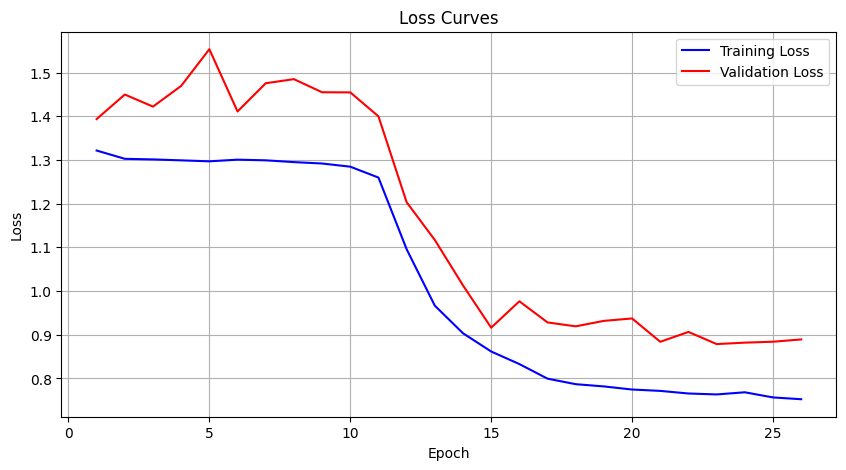

In [ ]:
import matplotlib.pyplot as plt

num_epochs = list(range(1, len(train_loss) + 1))

plt.figure(figsize=(10, 5))
plt.plot(num_epochs, train_loss, color='blue', label='Training Loss')
plt.plot(num_epochs[:len(val_loss)], val_loss, color='red', label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


*PERFORMANCE METRICS ON FINETUNED MODEL*

In [ ]:
# evaluation

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize images to 224x224
    transforms.ToTensor(),
])

test_dir = '/content/drive/MyDrive/Charcoal Dataset for Model/Test'
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32)

# load fine tuned model
model_path = '/content/drive/MyDrive/exp1.5_finetune.pth'
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=num_classes)

model.load_state_dict(torch.load(model_path, map_location=device))

# Move model to GPU if available
model.to(device)

# Evaluate the model
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs).logits

        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.view(-1).cpu().numpy())
        y_true.extend(labels.view(-1).cpu().numpy())

# Calculate metrics
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


               precision    recall  f1-score   support

  P. coronata       0.75      0.43      0.55         7
P. cynaroides       0.76      0.72      0.74        18
    P. mundii       0.40      0.86      0.55         7
    P. repens       0.50      0.17      0.25         6

     accuracy                           0.61        38
    macro avg       0.60      0.54      0.52        38
 weighted avg       0.65      0.61      0.59        38



*SALIENCY GRAPHS*

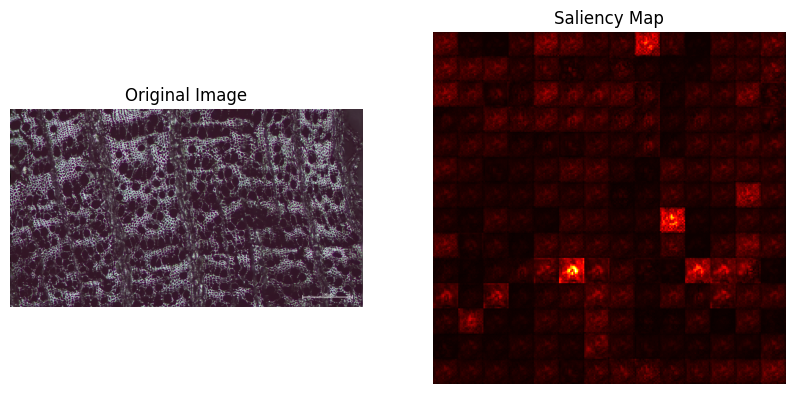

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load an image
image_path = '/content/drive/MyDrive/Charcoal Dataset for Model/Validation/P. coronata/30P. coronata.tiff'
image = Image.open(image_path)

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = transform(image).unsqueeze(0)
input_tensor = input_tensor.to(device)

# Forward pass
model.eval()
input_tensor.requires_grad_(True)
outputs = model(input_tensor).logits

score, indices = torch.max(outputs, 1)
score.backward()

# Saliency map
saliency, _ = torch.max(input_tensor.grad.data.abs(), dim=1)
saliency = saliency.reshape(224, 224)

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(saliency.cpu(), cmap='hot')
plt.title('Saliency Map')
plt.axis('off')
plt.show()


# **EXPERIMENT 2: PRETRAINED ON FULL DATASET FOR 2 EPOCHS**

*PRE-TRAINING ON CELL IMAGE DATASET(RAN ON HPC)*

In [ ]:
# refer to pre training notebook

*FINETUNING ON CHARCOAL DATASET*

In [ ]:
import torch

def train(model, num_epochs, optimizer, criterion, train_loader, val_loader, device, name, patience=3):
    # learning rate scheduler
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8, 16, 24], gamma=0.1)

    last_val_loss = None
    epochs_no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # training
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        #print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

        # validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # learning rate scheduler step
        scheduler.step()

        # early stopping
        if last_val_loss is not None and avg_val_loss >= last_val_loss:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping")
                break
        else:
            epochs_no_improve = 0
            best_model_wts = model.state_dict()

        last_val_loss = avg_val_loss


    # save the best model found during training
    path = f'/content/drive/MyDrive/{name}.pth'
    torch.save(best_model_wts, path)


    return train_losses, val_losses

In [ ]:
# load personally pre trained ViT and finetune on charcoal dataset
!pip install timm
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import AdamW
import torch
from torchvision import datasets, transforms
from PIL import Image
import shutil
import os
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    # Add other transformations as needed
])

train_dir = '/content/drive/MyDrive/Charcoal Dataset for Model/Train'
val_dir = '/content/drive/MyDrive/Charcoal Dataset for Model/Validation'
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

num_classes = len(train_dataset.classes)

# load pre-trained model
ckpt_path = '/content/drive/MyDrive/model-checkpoints/best_model-epoch_2-acc_0.6018.pth'
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=5)
checkpoint = torch.load(ckpt_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.head = torch.nn.Linear(model.head.in_features, num_classes)   # replace the classifier head of the model

# move model to GPU if available
# device = torch.device("mps")
model.to(device)

optimizer = AdamW(model.parameters(), lr=0.001) # adam w/ weight decay
criterion = nn.CrossEntropyLoss()

# training and validation
num_epochs = 30

train_loss, val_loss = train(model, num_epochs, optimizer, criterion, train_loader, val_loader, device, 'exp2_finetune')

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch [1/30]
Training Loss: 1.2810, Validation Loss: 1.5142
Epoch [2/30]
Training Loss: 1.2261, Validation Loss: 1.2787
Epoch [3/30]
Training Loss: 1.2182, Validation Loss: 1.4020
Epoch [4/30]
Training Loss: 1.2069, Validation Loss: 1.2790
Epoch [5/30]
Training Loss: 1.1808, Validation Loss: 1.3623
Epoch [6/30]
Training Loss: 1.1598, Validation Loss: 1.3319
Epoch [7/30]
Training Loss: 1.1622, Validation Loss: 1.2900
Epoch [8/30]
Training Loss: 1.1274, Validation Loss: 1.2631
Epoch [9/30]
Training Loss: 1.0929, Validation Loss: 1.2289
Epoch [10/30]
Training Loss: 1.0732, Validation Loss: 1.2024
Epoch [11/30]
Training Loss: 1.0635, Validation Loss: 1.1985
Epoch [12/30]
Training Loss: 1.0562, Validation Loss: 1.1849
Epoch [13/30]
Training Loss: 1.0601, Validation Loss: 1.1876
Epoch [14/30]
Training Loss: 1.0470, Validation Loss: 1.1986
Epoch [15/30]
Training Loss: 1.0404, Validation Loss: 1.2029
Early stopping


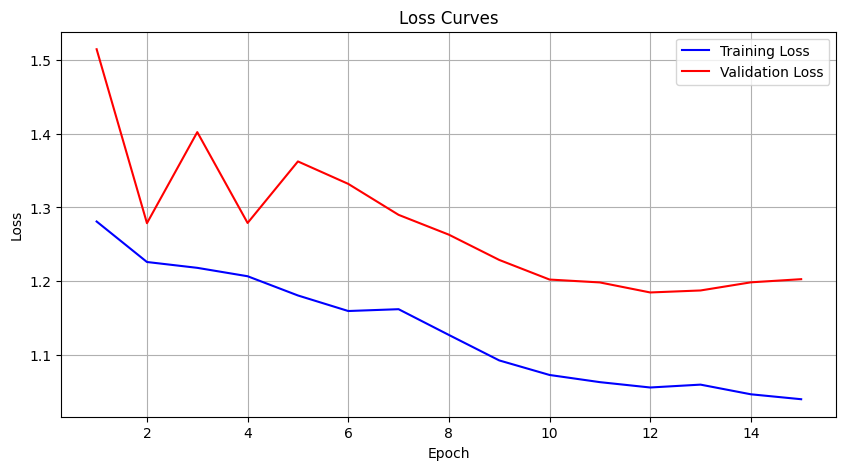

In [ ]:
import matplotlib.pyplot as plt

num_epochs = list(range(1, len(train_loss) + 1))

plt.figure(figsize=(10, 5))
plt.plot(num_epochs, train_loss, color='blue', label='Training Loss')
plt.plot(num_epochs[:len(val_loss)], val_loss, color='red', label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

*PERFORMANCE METRICS ON FINETUNED MODEL*

In [ ]:
# evaluation

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
])
test_dir = '/content/drive/MyDrive/Charcoal Dataset for Model/Test'
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32)

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = '/content/drive/MyDrive/exp2_finetune.pth'
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=4)
model.load_state_dict(torch.load(model_path, map_location=device))

# Move model to GPU if available
model.to(device)

# Evaluate the model
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.view(-1).cpu().numpy())
        y_true.extend(labels.view(-1).cpu().numpy())

# Calculate metrics
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

               precision    recall  f1-score   support

  P. coronata       0.40      0.57      0.47         7
P. cynaroides       0.64      0.78      0.70        18
    P. mundii       0.40      0.29      0.33         7
    P. repens       0.00      0.00      0.00         6

     accuracy                           0.53        38
    macro avg       0.36      0.41      0.38        38
 weighted avg       0.45      0.53      0.48        38



*SALIENCY GRAPHS*

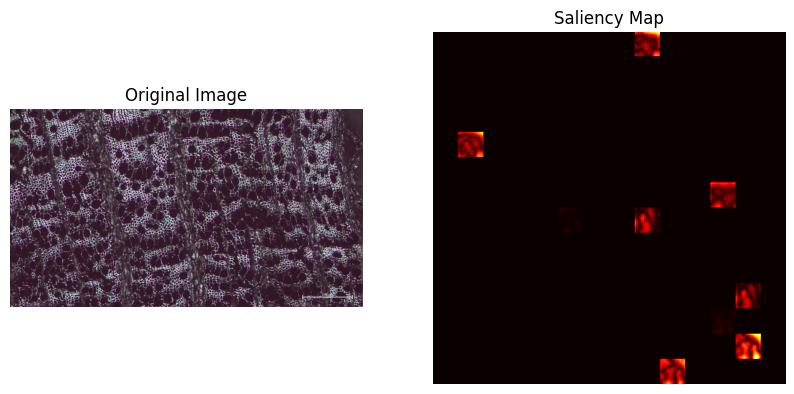

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load an image
image_path = '/content/drive/MyDrive/Charcoal Dataset for Model/Validation/P. coronata/30P. coronata.tiff'
image = Image.open(image_path)

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = transform(image).unsqueeze(0)
input_tensor = input_tensor.to(device)

# Forward pass
model.eval()
input_tensor.requires_grad_(True)
outputs = model(input_tensor)

score, indices = torch.max(outputs, 1)
score.backward()

# Saliency map
saliency, _ = torch.max(input_tensor.grad.data.abs(), dim=1)
saliency = saliency.reshape(224, 224)

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(saliency.cpu(), cmap='hot')
plt.title('Saliency Map')
plt.axis('off')
plt.show()


# **EXPERIMENT 2.5: PRE TRAINED ON 20% OF THE DATASET FOR 16 EPOCHS**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    # Add other transformations as needed
])

train_dir = '/content/drive/MyDrive/Charcoal Dataset for Model/Train'
val_dir = '/content/drive/MyDrive/Charcoal Dataset for Model/Validation'
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

num_classes = len(train_dataset.classes)

# load pre-trained model
ckpt_path = '/content/drive/MyDrive/model-checkpoints/best_model-subset_0.2-epoch_16-acc_0.8854.pth'
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=5)
checkpoint = torch.load(ckpt_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.head = torch.nn.Linear(model.head.in_features, num_classes)   # replace the classifier head of the model

# move model to GPU if available
# device = torch.device("mps")
model.to(device)

optimizer = AdamW(model.parameters(), lr=0.001) # adam w/ weight decay
criterion = nn.CrossEntropyLoss()

# training and validation
num_epochs = 30

train_loss, val_loss = train(model, num_epochs, optimizer, criterion, train_loader, val_loader, device, 'exp2.5_finetune')

Epoch [1/30]
Training Loss: 1.7763, Validation Loss: 1.8466
Epoch [2/30]
Training Loss: 1.3247, Validation Loss: 1.5280
Epoch [3/30]
Training Loss: 1.3100, Validation Loss: 1.4984
Epoch [4/30]
Training Loss: 1.3505, Validation Loss: 1.3306
Epoch [5/30]
Training Loss: 1.3191, Validation Loss: 1.6131
Epoch [6/30]
Training Loss: 1.3213, Validation Loss: 1.5773
Epoch [7/30]
Training Loss: 1.3061, Validation Loss: 1.4479
Epoch [8/30]
Training Loss: 1.3134, Validation Loss: 1.4583
Epoch [9/30]
Training Loss: 1.3014, Validation Loss: 1.5480
Epoch [10/30]
Training Loss: 1.2948, Validation Loss: 1.4529
Epoch [11/30]
Training Loss: 1.2949, Validation Loss: 1.5166
Epoch [12/30]
Training Loss: 1.2940, Validation Loss: 1.5292
Epoch [13/30]
Training Loss: 1.2924, Validation Loss: 1.4500
Epoch [14/30]
Training Loss: 1.2983, Validation Loss: 1.5003
Epoch [15/30]
Training Loss: 1.2911, Validation Loss: 1.4628
Epoch [16/30]
Training Loss: 1.2945, Validation Loss: 1.5344
Epoch [17/30]
Training Loss: 1.29

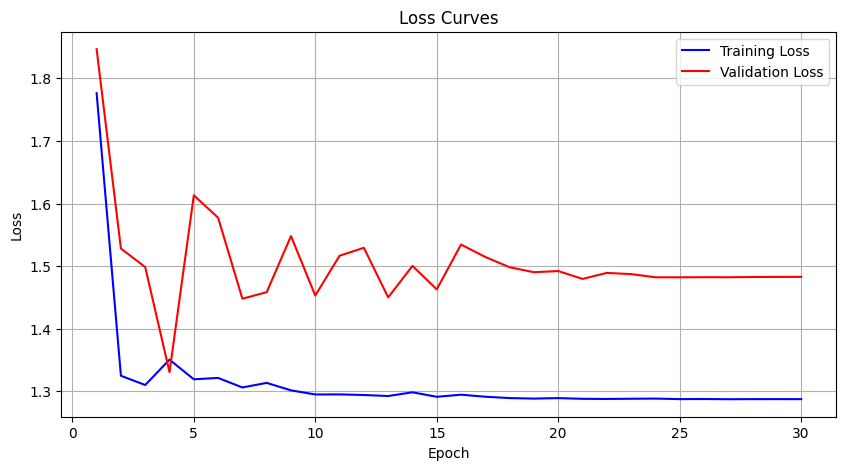

In [ ]:
import matplotlib.pyplot as plt

num_epochs = list(range(1, len(train_loss) + 1))

plt.figure(figsize=(10, 5))
plt.plot(num_epochs, train_loss, color='blue', label='Training Loss')
plt.plot(num_epochs[:len(val_loss)], val_loss, color='red', label='Validation Loss')  # Adjust to length of val_loss
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

*PERFORMANCE METRICS ON FINETUNED MODEL*

In [ ]:
# evaluation

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
])
test_dir = '/content/drive/MyDrive/Charcoal Dataset for Model/Test'
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32)

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = '/content/drive/MyDrive/exp2.5_finetune.pth'
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=4)
model.load_state_dict(torch.load(model_path, map_location=device))

# Move model to GPU if available
model.to(device)

# Evaluate the model
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.view(-1).cpu().numpy())
        y_true.extend(labels.view(-1).cpu().numpy())

# Calculate metrics
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

               precision    recall  f1-score   support

  P. coronata       0.00      0.00      0.00         7
P. cynaroides       0.47      1.00      0.64        18
    P. mundii       0.00      0.00      0.00         7
    P. repens       0.00      0.00      0.00         6

     accuracy                           0.47        38
    macro avg       0.12      0.25      0.16        38
 weighted avg       0.22      0.47      0.30        38



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


*SALIENCY GRAPHS*

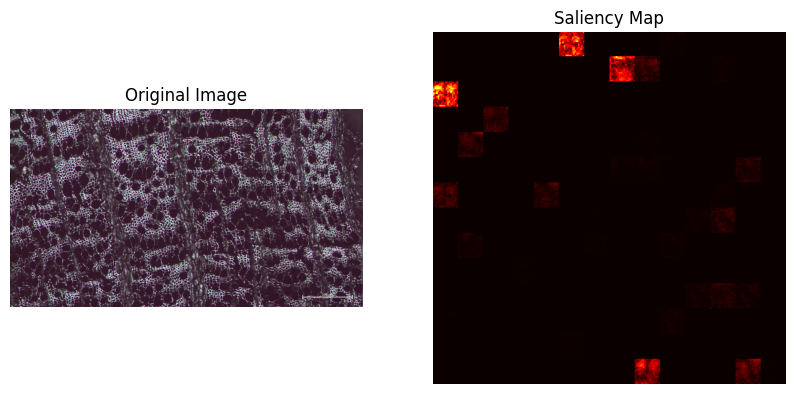

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load an image
image_path = '/content/drive/MyDrive/Charcoal Dataset for Model/Validation/P. coronata/30P. coronata.tiff'
image = Image.open(image_path)

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = transform(image).unsqueeze(0)
input_tensor = input_tensor.to(device)

# Forward pass
model.eval()
input_tensor.requires_grad_(True)
outputs = model(input_tensor)

score, indices = torch.max(outputs, 1)
score.backward()

# Saliency map
saliency, _ = torch.max(input_tensor.grad.data.abs(), dim=1)
saliency = saliency.reshape(224, 224)

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(saliency.cpu(), cmap='hot')
plt.title('Saliency Map')
plt.axis('off')
plt.show()


*SIMILARITY SCORES*

In [ ]:
#SIMILARITY SCORES BETWEEN IMAGENET AND TARGET CHARCOAL DATASET
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define paths to datasets
charcoal_images_path = '/content/drive/My Drive/charcoal_sample/'
imagenet_sample_path = '/content/drive/My Drive/imagenet_sample/'

# Function to load and prepare an image, supporting .tiff
def load_and_prepare_image(img_path):
    img = Image.open(img_path)  # Use PIL to open image files
    img = img.resize((224, 224))  # Resize to the required dimensions for the model
    img_array = np.array(img)  # Convert to numpy array
    if img_array.ndim == 2:  # If the image is grayscale, convert to three channels
        img_array = np.stack([img_array]*3, axis=-1)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return preprocess_input(img_array)  # Preprocess for model input

# Load all images from both datasets
def load_images_from_folder(folder):
    image_files = [os.path.join(folder, img) for img in os.listdir(folder) if img.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff'))]
    images = []
    for file in image_files:
        try:
            img = load_and_prepare_image(file)
            images.append(img)
        except Exception as e:
            print(f"Failed to load image {file}: {e}")
    return images

charcoal_images = load_images_from_folder(charcoal_images_path)
imagenet_images = load_images_from_folder(imagenet_sample_path)

print(f"Loaded {len(charcoal_images)} charcoal images.")
print(f"Loaded {len(imagenet_images)} imagenet images.")

# Load ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

# Function to extract features
def extract_features(img_array, model):
    return model.predict(img_array)

def compute_average_similarity(charcoal_img, imagenet_images, model):
    charcoal_features = extract_features(charcoal_img, model)
    scores = []
    for img in imagenet_images:
        imagenet_features = extract_features(img, model)
        score = cosine_similarity(charcoal_features, imagenet_features)[0][0]
        scores.append(score)
    return np.mean(scores)

# Compute the average similarity score for each charcoal image
average_scores = [compute_average_similarity(charcoal_img, imagenet_images, model) for charcoal_img in charcoal_images]

# Compute the overall average similarity
overall_average_similarity = np.mean(average_scores)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 29 charcoal images.
Loaded 102 imagenet images.
1/1 [==============================] - 0s 23ms/step


Exception ignored in: <function _xla_gc_callback at 0x7b46634a1c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


1/1 [==============================] - 0s 28ms/step


In [ ]:
print(overall_average_similarity)

0.16297969


In [ ]:


# Define paths to datasets
charcoal_images_path = '/content/drive/My Drive/charcoal_sample/'
cell_sample_path = '/content/drive/My Drive/cell_images2/'
from PIL import Image
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input

def load_and_prepare_image(img_path):
    img = Image.open(img_path)  # Open image with PIL
    img = img.convert('RGB')  # Convert image to RGB, dropping alpha channel if it exists
    img = img.resize((224, 224))  # Resize image to the size expected by the model
    img_array = np.array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return preprocess_input(img_array)  # Preprocess for model input


# Load all images from both datasets
def load_images_from_folder(folder):
    image_files = [os.path.join(folder, img) for img in os.listdir(folder) if img.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', 'tif'))]
    images = []
    for file in image_files:
        try:
            img = load_and_prepare_image(file)
            images.append(img)
        except Exception as e:
            print(f"Failed to load image {file}: {e}")
    return images

charcoal_images = load_images_from_folder(charcoal_images_path)
cell_images = load_images_from_folder(cell_sample_path)

print(f"Loaded {len(charcoal_images)} charcoal images.")
print(f"Loaded {len(cell_images)} imagenet images.")

# Load ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

# Function to extract features
def extract_features(img_array, model):
    return model.predict(img_array)

def compute_average_similarity(charcoal_img, cell_images, model):
    charcoal_features = extract_features(charcoal_img, model)
    scores = []
    for img in cell_images:
        cell_features = extract_features(img, model)
        score = cosine_similarity(charcoal_features, cell_features)[0][0]
        scores.append(score)
    return np.mean(scores)

# Compute the average similarity score for each charcoal image
average_scores = [compute_average_similarity(charcoal_img, cell_images, model) for charcoal_img in charcoal_images]

# Compute the overall average similarity
overall_average_similarity_cells = np.mean(average_scores)


Loaded 29 charcoal images.
Loaded 19 imagenet images.
1/1 [==============================] - 0s 31ms/step


In [ ]:
print(overall_average_similarity_cells)

0.24659652
